#  Fashion - MNIST dataset classification with CNN 

Phung Tien Hao

---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Change dir

In [2]:
%cd '/content/gdrive/My Drive/Senior/Computer vision in application/Lab 01'
%cat requirements.txt

/content/gdrive/My Drive/Senior/Computer vision in application/Lab 01
tensorflow-gpu==1.13.1
scipy==1.2.1
scikit-learn
opencv-python
h5py
matplotlib
Pillow
requests
psutil
pandas

In [34]:
!pip install -r requirements.txt

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
The folder you are executing pip from can no longer be found.


# 1. Import lib

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from cnn_ultils import *
from datetime import datetime
import os
# Set seed
tf.set_random_seed(1)
np.random.seed(1)

# Embedd image into notebook
%matplotlib inline

# 2. Load dataset

Class names are used for ploting

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [0]:
(X_train, Y_train), (X_test, Y_test) = load_data("fashionmnist/fashion-mnist_train.csv", "fashionmnist/fashion-mnist_test.csv")

Explore dataset and shuffle dataset

In [31]:
# Reshape training and testing image
X_train, X_test = X_train.reshape((-1, 28, 28, 1)), X_test.reshape((-1, 28, 28, 1))
Y_train, Y_test = convert_to_one_hot(Y_train, 10), convert_to_one_hot(Y_test, 10)

(X_train, Y_train), (X_val, Y_val) = train_val_split(X_train, Y_train, val_size=10000)    

# Normalize data x to be in range 0-1
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_val:", X_val.shape)
print("Y_val:", Y_val.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)

X_train: (50000, 28, 28, 1)
Y_train: (50000, 10)
X_val: (10000, 28, 28, 1)
Y_val: (10000, 10)
X_test: (10000, 28, 28, 1)
Y_test: (10000, 10)


## Plot some training images

NameError: ignored

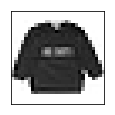

In [6]:
# Plot 25 first examples from training set
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape((28, 28)), cmap = "binary")
    plt.xlabel(class_names[np.argmax(Y_train[i])])

plt.show()

## Data augmentation

In [0]:
def horizontal_flip(img):
    """
    Horizontal Flip augmentation

    Args:
        img: Input image
    Returns:
        Flip image
    """
    img = tf.image.flip_left_right(img)

    return img

def crop(img):
    """
    Random crop augmentation

    Args:
        img: Input image
    Returns:
        Croped image
    """
    img = tf.image.random_crop(img, size=[23, 23, 1]) # crop size = 0.8 * img size
    img = tf.image.resize_image_with_pad(img, 28, 28, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img

In [28]:
"""Data augmentation"""
rand_index = np.random.choice(50000, 10000, replace=False)
aug_dataset = X_train.copy()[rand_index]
aug_Y = Y_train.copy()[rand_index]

augmentation_methods = [horizontal_flip, crop]

aug_datasets = []
sess = tf.Session()
for f in augmentation_methods:
    # Apply an augmentation only in 50% of the dataset
    aug_dataset = tf.map_fn(lambda x: f(x), aug_dataset, parallel_iterations=10)
    aug_dataset = tf.map_fn(lambda x: tf.clip_by_value(x, 0, 1), aug_dataset) # Cut values out of range (0, 1)
    aug_datasets.append(sess.run(aug_dataset))
sess.close()

aug_datasets = np.concatenate((aug_datasets[0], aug_datasets[1]), axis=0)
aug_Y = np.concatenate((aug_Y, aug_Y), axis=0)
print(aug_datasets.shape)

X_train = np.concatenate((X_train, aug_datasets), axis=0)
Y_train = np.concatenate((Y_train, aug_Y), axis=0)
print(X_train.shape)
print(Y_train.shape)

(20000, 28, 28, 1)
(70000, 28, 28, 1)
(70000, 10)


# 3. Create placeholders

In [0]:
def create_placeholders(nH0, nW0, nC0, nY):
    '''
    Purpose: Create placeholders for input data. 
    Construct place for input data that allows to specify values later
    
    Input:
        nH0: the height of input data (image)
        nW0: the width of input data (image)
        nC0: the number of channels of input data (image)
        nY: the number of channels of Y
      
    Output:
        X, Y: placeholders for input data
        keep_prob: use for dropout
        is_training: use for batchnorm
    '''
    X = tf.placeholder(dtype = tf.float32, shape = [None, nH0, nW0, nC0], name='input')
    Y = tf.placeholder(dtype = tf.float32, shape = [None, nY], name = 'label')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return X, Y, keep_prob, is_training

In [8]:
X, Y, keep_prob, is_training = create_placeholders(3, 3, 2, 1)

print(X)
print(Y)
print(keep_prob)
print(is_training)

Tensor("input:0", shape=(?, 3, 3, 2), dtype=float32)
Tensor("label:0", shape=(?, 1), dtype=float32)
Tensor("keep_prob:0", dtype=float32)
Tensor("is_training:0", dtype=bool)


# 4. Initialize parameters

In [0]:
def init_params():
    # '''Init params to build neural network using He initialization
    # Model includes 2 CONV layes so that i init 2 parameters W1, W2.

    # Output:
    #     params: dictionary contains initial parameters W1, W2
    # '''
    # # tf.contrib.layers.xavier_initializer(seed = 0)
    # # mode='FAN_IN': # Count only number of input connections.
    # W1a = tf.get_variable('W1a', [3, 3, 1, 32], initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', seed=0, uniform=False))
    # W1b = tf.get_variable('W1b', [3, 3, 32, 32], initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', seed=0, uniform=False))

    # W2a = tf.get_variable('W2a', [3, 3, 32, 64], initializer =tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', seed=0, uniform=False))
    # W2b = tf.get_variable('W2b', [3, 3, 64, 64], initializer =tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', seed=0, uniform=False))
    
    # # Return params dictionary
    # params = {'W1a': W1a, 'W1b': W1b, \
    #           'W2a': W2a, 'W2b': W2b}

    '''Init params to build neural network using He initialization
    Model includes 2 CONV layes so that i init 2 parameters W1, W2.

    Output:
        params: dictionary contains initial parameters W1, W2
    '''
    # tf.contrib.layers.xavier_initializer(seed = 0)
    # mode='FAN_IN': # Count only number of input connections.
    W1 = tf.get_variable('W1', [5, 5, 1, 32], initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', seed=0, uniform=False))
    W2 = tf.get_variable('W2', [5, 5, 32, 64], initializer =tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', seed=0, uniform=False))
    
    # Return params dictionary
    params = {'W1': W1, 'W2': W2}
    
    return params

In [10]:
tf.reset_default_graph()
# Start session
with tf.Session() as sess:
    params = init_params()
    init = tf.global_variables_initializer()
    sess.run(init)
    # eval() to access init params
    print(params['W1'].eval()[2, 1, 0])
    print(params['W2'].eval()[2, 1, 0])

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

[ 0.27962556  0.01836919  0.5818591   0.15281099  0.16358273 -0.33858886
 -0.15803637  0.01159567 -0.02905411 -0.16152051 -0.5868845   0.4466479
  0.1160896   0.1171051   0.2162253   0.21260528  0.24762763  0.16704114
  0.14749299  0.05631219 -0.11084587  0.5368453   0.5445989  -0.33338666
  0.22532874  0.3943117  -0.25896066 -0.47179097  0.24023701  0.00590787
 -0.18029146  0.45188966]
[-0.06015451 -0.01164385  0.0289786  -0.03375296 -0.06890791 -0.02539449
  0.0090615  -0.011644   -0.08910772  0.0496453  -0.01981989  0.07181952
  0.11395305 -0.06079784 -0.01650224  0.02331122  0.07756662 -0.00081236
  0.0847094  -0.00965964  0

# 5. Forward propagation

In [0]:
def block1(X, keep_prob, W, is_training, block_number):
    """
    Block i: CONV -> BatchNorm -> Pool -> Dropout (i = block_number)

    Input:
        X: shape [m, nHi-1, nWi-1, nCi-1]
        keep_prob: placeholder (tf.float32) used for dropout
        W: parameter of CONV i (Wi)
        is_training: placeholder (tf.bool) used for batchnorm
        block_number
    Output:
        X: output of droupout layer ([m, nHi-1/srides[1], nWi-1/strides[2], nCi])
    """

    # CONVi: stride 1, padding 'SAME'
    with tf.variable_scope('CONV'+str(block_number), reuse = tf.AUTO_REUSE):
        # Zi and Ai shape: [m, nHi-1, nWi-1, nCi]
        X = tf.nn.conv2d(X, W, strides = [1,1,1,1], padding = 'SAME')  #Zi
        # RELUi: same shape as Zi
        X = tf.nn.relu(X) # Ai
        # Batch normalization
        X = tf.layers.batch_normalization(inputs=X, axis=-1, training=is_training)

    with tf.variable_scope('POOL'+str(block_number), reuse = tf.AUTO_REUSE):
        # POOL1: ksize [1, 2, 2, 1], strides = [1, 2, 2, 1]
        # P1 shape: [m, nHi, nWi, nCi] = [m, nHi-1/srides[1], nWi-1/strides[2], nCi]
        X = tf.nn.max_pool(X, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME') # Pi
    
    with tf.variable_scope('Dropout'+str(block_number), reuse = tf.AUTO_REUSE):
        X = tf.nn.dropout(X, keep_prob) # Di

    return X    

In [0]:
def block2(X, keep_prob, W_block, is_training, block_number):
    """
    Block i: CONVa -> BatchNorm -> CONVb -> BatchNorm -> Pool -> Dropout (i = block_number)

    Input:
        X: shape [m, nHi-1, nWi-1, nCi-1]
        keep_prob: placeholder (tf.float32) used for dropout
        W_block: tuple of parameter of CONV i (Wa, Wb)
        is_training: placeholder (tf.bool) used for batchnorm
        block_number
    Output:
        X: output of droupout layer ([m, nHi-1/srides[1], nWi-1/strides[2], nCi])
    """

    Wa, Wb = W_block[0], W_block[1]

    # CONVia: stride 1, padding 'SAME'
    with tf.variable_scope('CONV'+str(block_number)+'a', reuse = tf.AUTO_REUSE):
        # Zi and Ai shape: [m, nHi-1, nWi-1, nCi]
        X = tf.nn.conv2d(X, Wa, strides = [1,1,1,1], padding = 'SAME')  #Zi
        # RELUi: same shape as Zi
        X = tf.nn.relu(X) # Ai
        # Batch normalization
        X = tf.layers.batch_normalization(inputs=X, axis=-1, training=is_training)

    # CONVib: stride 1, padding 'SAME'
    with tf.variable_scope('CONV'+str(block_number)+'b', reuse = tf.AUTO_REUSE):
        # Zi and Ai shape: [m, nHi-1, nWi-1, nCi]
        X = tf.nn.conv2d(X, Wb, strides = [1,1,1,1], padding = 'SAME')  #Zi
        # RELUi: same shape as Zi
        X = tf.nn.relu(X) # Ai
        # Batch normalization
        X = tf.layers.batch_normalization(inputs=X, axis=-1, training=is_training)

    with tf.variable_scope('POOL'+str(block_number), reuse = tf.AUTO_REUSE):
        # POOL1: ksize [1, 2, 2, 1], strides = [1, 2, 2, 1]
        # P1 shape: [m, nHi, nWi, nCi] = [m, nHi-1/srides[1], nWi-1/strides[2], nCi]
        X = tf.nn.max_pool(X, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME') # Pi
    
    with tf.variable_scope('Dropout'+str(block_number), reuse = tf.AUTO_REUSE):
        X = tf.nn.dropout(X, keep_prob) # Di

    return X    

In [0]:
def forward_propagation(X, keep_prob, params):
    '''Perfome forward propagation
        Input -> CONV1 -> RELU1 -> POOL1 -> CONV2 -> RELU2 -> POOL2 -> FC -> DROPOUT -> SOFTMAX
    
    Input:
      X: shape [m, nH0, nW0, nC0]
      keep_prob: placeholder (tf.float32) used for dropout
      params: dictionary including 'W1' and 'W2' for CONV1 and CONV2 respectively

    Output:
      Z4: shape [m, 10] which is a output of SOFTMAX layer (but softmax was computed by compute_cost function)
    '''
    
    # Get 2 params
    W1, W2 = params['W1'], params['W2']
    
    
    # CONV1: stride 1, padding 'SAME'
    with tf.variable_scope('CONV1', reuse = tf.AUTO_REUSE):
        # Z1 and A1 shape: [m, nH0, nW0, nC1]
        Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')  #[]
        # RELU1
        A1 = tf.nn.relu(Z1)
        
    with tf.variable_scope('POOL1', reuse = tf.AUTO_REUSE):
        # POOL1: ksize [1, 2, 2, 1], strides = [1, 2, 2, 1]
        # P1 shape: [m, nH1, nW1, nC1] = [m, nH0/srides[1], nW0/strides[2], nC1]
        P1 = tf.nn.max_pool(A1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
        
    with tf.variable_scope('CONV2', reuse = tf.AUTO_REUSE):
        # CONV2: stride 1, padding "SAME"
        # Z2 and A2 shape: [m, nH1, nW1, nC2]
        Z2 = tf.nn.conv2d(P1, W2, strides = [1, 1, 1, 1], padding = 'SAME')
        # RELU2
        A2 = tf.nn.relu(Z2)
    
    with tf.variable_scope('POOL2', reuse = tf.AUTO_REUSE):
        # POOL2: ksize = [2, 2], strides = 2
        # P2 shape: [m, nH2, nW2, nC2] = [m, nH1/strides[1], nW1/strides[2], nC2]
        P2 = tf.nn.max_pool(A2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    with tf.variable_scope('FLATTEN', reuse = tf.AUTO_REUSE):
        # flatten feature map
        # F shape: [m, nH2*nW2*nC2]
        F = tf.contrib.layers.flatten(P2)
        
    with tf.variable_scope('FC1', reuse = tf.AUTO_REUSE):
        # FC1: with 1024 units and activation_fn = 'relu'
        # FC1 shape: [m, 1024]
        FC1 = tf.contrib.layers.fully_connected(F, num_outputs = 1024, activation_fn = tf.nn.relu)
    
    with tf.variable_scope('Dropout3', reuse = tf.AUTO_REUSE):
        D = tf.nn.dropout(FC1, keep_prob)
    
    with tf.variable_scope('FC2', reuse = tf.AUTO_REUSE):
        # FC2: with 10 units and set activation_fn = None because softmax function is computed separately
        # FC2: [m, 10]
        Z4 = tf.compat.v1.layers.Dense(units = 10, activation = None, name = 'Z4')(D)
    
    return Z4

In [0]:
def forward_propagation1(X, keep_prob, params, is_training):
    '''Perfome forward propagation
        Input -> CONV1 -> RELU1 -> POOL1 -> CONV2 -> RELU2 -> POOL2 -> FC -> DROPOUT -> SOFTMAX
    
    Input:
      X: shape [m, nH0, nW0, nC0]
      keep_prob: placeholder (tf.float32) used for dropout
      params: dictionary including 'W1' and 'W2' for CONV1 and CONV2 respectively
      is_training: placeholder (tf.bool) used for batchnorm

    Output:
      Z4: shape [m, 10] which is a output of SOFTMAX layer (but softmax was computed by compute_cost function)
    '''
    
    # Get 2 block params
    # W1, W2 = (params['W1a'], params['W1b']), (params['W2a'], params['W2b'])
    W1, W2 = params['W1'], params['W2']

    # Block 1: CONV -> BatchNorm -> Pool -> Dropout
    X = block1(X, keep_prob, W1, is_training, 1)
    
    # Block 2: CONV -> BatchNorm -> Pool -> Dropout
    X = block1(X, keep_prob, W2, is_training, 2)
    
    # Flatten -> FC -> Dropout -> FC
    with tf.variable_scope('FLATTEN', reuse = tf.AUTO_REUSE):
        # flatten feature map
        # F shape: [m, nH2*nW2*nC2]
        F = tf.contrib.layers.flatten(X)
        
    with tf.variable_scope('FC1', reuse = tf.AUTO_REUSE):
        # FC1: with 1024 units and activation_fn = 'relu'
        # FC1 shape: [m, 1024]
        FC1 = tf.contrib.layers.fully_connected(F, num_outputs = 1024, activation_fn = tf.nn.relu)
    
    with tf.variable_scope('Dropout3', reuse = tf.AUTO_REUSE):
        D = tf.nn.dropout(FC1, keep_prob)
    
    with tf.variable_scope('FC2', reuse = tf.AUTO_REUSE):
        # FC2: with 10 units and set activation_fn = None because softmax function is computed separately
        # FC2: [m, 10]
        Z4 = tf.compat.v1.layers.Dense(units = 10, activation = None, name = 'Z4')(D)
    
    return Z4

In [39]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y, keep_prob, is_training = create_placeholders(30, 30, 1, 1)
    params = init_params()
    Z4 = forward_propagation(X, keep_prob, params)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z4, {X: np.random.randn(2, 30, 30, 1), Y: np.random.randn(2, 1), keep_prob: 1.0, is_training:False})
    print(a)


[[ 3.8492644  -1.8625023   2.8157747   1.7608798   4.2834272   3.8852968
  -1.4115161  -0.94252396 -6.434965   -3.9633875 ]
 [ 3.4344425  -2.9129243   3.5866396   1.9334693   4.1646852   5.9458966
  -1.7618097   2.4452896  -8.07802    -3.9167569 ]]


# 6. Compute cost

In [0]:
def compute_cost(Z4, Y):
    '''
    Purpose: Compute cost by perfoming sofmax function first and then using cross-entropy as loss function
    Input:
      Z4: logits (not probability) with shape [m, 10]
      Y: labels with shape [m, 10]
      
     Output:
      cost (lost): cross_entropy loss (scalar)
    '''
    # Compute mean of all example to get overall cost
    # Loss function: Cross-entropy
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z4, labels = Y))
    return cost

# 7. Build model function

Ramdomize minibatches by shuffling dataset

# Fit model

In [0]:
def fit_model(X_train, Y_train, X_val, Y_val, model_name, learning_rate = 0.001, no_epochs = 100, minibatch_size = 50, keep_prob_input = 1.0, weight_decay=5e-4, plot_learning_curve = True, model_number=0):
    '''
    Fit model includes the following steps:
      Init computation graph. 
      Create placeholders for training set X and Y.
      Init parameters W1 and W2 for model.
      Forward propagation.
      Compute cost
      Create optimizer to minimize cost and tensorflow will perfome back prop for us
      Init global variables for model
      Start session and execute above operators per epoch
    
    Input:
      X_train [m, nH0, nW0, nC0]: training examples
      Y_train [m, 10]: training labels
      X_val [m_val, nH0, nW0, nC0]: validating examples
      Y_val [m_val, 10]: validating labels
      learning_rate: defaults 0.001 (1e-4)
      no_epochs: the number of epochs (default: 100)
      minibatch_size: defaults 50
      weight_decay: use for L2 regularization
      plot_learning_curve: If True, it will plot the learning curve of costs each 5 epochs (Default: True).
      model_number: number of model to use. There are 2: 0 and 1.
      
    Output:
      training_accuracy (%)
      val_accuracy (%)
      params: final parameters of model
      
    ***By defaults: It will plot learning curve for training examples
    '''
    
    tf.reset_default_graph()
    
    # Get shape of input layer
    m, nH0, nW0, nC0 = X_train.shape
    nY = Y_train.shape[-1]
    
    # costs list
    costs = []
    
    # Create placeholders for traing set X and Y
    X, Y, keep_prob, is_training = create_placeholders(nH0, nW0, nC0, nY)
    
    # init params
    params = init_params()
    
    # Forward prop: to get logits
    if model_number == 0:
        Z4 = forward_propagation(X, keep_prob, params)
    else:
        Z4 = forward_propagation1(X, keep_prob, params, is_training)
    # Compute cost
    cost = compute_cost(Z4, Y)
    
    # Cost function with L2 Regularization with weight_decay
    # regularizers = tf.nn.l2_loss(params['W1a']) + tf.nn.l2_loss(params['W1b']) + \
    #                tf.nn.l2_loss(params['W2a']) + tf.nn.l2_loss(params['W2b'])
    regularizers = tf.nn.l2_loss(params['W1']) + tf.nn.l2_loss(params['W2'])
    cost = tf.reduce_mean(cost + weight_decay * regularizers)

    # # Create cost_summary
    # cost_summary = tf.summary.scalar(name='Cost summary', tensor=cost)

    # Create optimizer operators. Use AdamOptimizer to minize cost
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(cost)
    
    # Create saver object to store all variables
    saver = tf.train.Saver()
    
    # Start Init glabal variable and Execute graph
    init = tf.global_variables_initializer()
    
    # Start session
    with tf.Session() as sess:
        # Create writter for log files inside session
        writter = tf.summary.FileWriter('../../logs/'+dtime, sess.graph)

        # Run the initialization
        sess.run(init)
        
        # Loop throuh the no_epochs
        for i in range(no_epochs):
            # Renew minibatch_cost each epoch
            minibatch_cost = 0
            # Compute the number of minibatch
            no_minibatches = int(m / minibatch_size)
            
            
            # Get random minibatches
            minibatches = random_minibatches(X_train, Y_train, minibatch_size, seed = i)
            
            # Loop each minibatch to compute cost
            for minibatch in minibatches:
                # Unpack
                minibatch_X, minibatch_Y = minibatch
                
                # Run the optimizer and cost operators
                # Feed minibatch_X and minibatch_Y into model
                _, epoch_cost = sess.run([train_op, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y, keep_prob: keep_prob_input, is_training: True})
                
                # Compute cost: divide epoch_cost with no_minibatches
                minibatch_cost += epoch_cost/no_minibatches
                
            # # Add minibatch_cost into writter for visualization
            # writter.add_summary(minibatch_cost, i)

            # Print cost each 5 epochs
            if i % 5 == 0:
                print('Cost after %d: %f' %(i, minibatch_cost))
            
            # Store cost to plot learning rate
            costs.append(minibatch_cost)
        
        
        if plot_learning_curve:
            # Plot learning rate
            plt.plot(np.squeeze(costs))
            plt.ylabel('Cost')
            plt.xlabel('Epoch per 5')
            plt.title('Learning rate = ' + str(learning_rate))
            plt.show()
        
        # Calculate the training accuracy and validating accuracy
        predict_op = tf.arg_max(Z4, 1)
        correct_prediction = tf.equal(predict_op, tf.arg_max(Y, 1))
        
        # Calculate the accuracy on training set and validating set
        # Perfome mean to compute accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        
        # Save graph
        saver.save(sess, model_name, global_step = 1000)
        
        # Execute computing accuracy
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, keep_prob: 1.0, is_training: False})
        val_accuracy = accuracy.eval({X: X_val, Y: Y_val, keep_prob: 1.0, is_training: False})
        
        print('Training accuracy:', train_accuracy)
        print('Validating accuracy:', val_accuracy)
        
    return train_accuracy, val_accuracy, params

Get datetime now presents the name of model and fit model

date and time = 07102019-124526
Current dir: /content/gdrive/My Drive/Senior/Computer vision in application/Lab 01/trained_models/07102019-124526
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Cost after 0: 1.007979


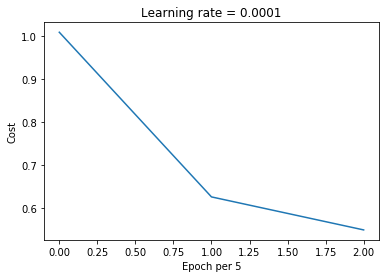

Training accuracy: 0.64638
Validating accuracy: 0.6453


In [43]:
# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dtime = now.strftime("%d%m%Y-%H%M%S")
print("date and time =", dtime)

# Create folder dtime
path = 'trained_models/'+dtime
os.mkdir(path)

# Change dir
os.chdir(path)
print("Current dir:", os.getcwd())

_, _, params = fit_model(X_train, Y_train, X_val, Y_val, \
                         no_epochs=3, learning_rate = 1e-4, keep_prob_input=0.5, weight_decay=5e-4, \
                         minibatch_size=50, plot_learning_curve=True, model_name=dtime, model_number=1)

# change dir back to original
os.chdir('../..')

# Evaluation

In [0]:
def evaluate(model_meta_file, X_test, Y_test):
  tf.reset_default_graph()
  with tf.Session() as sess:
    # Load model
    new_saver = tf.train.import_meta_graph(model_meta_file)
    # Restore the value of tensors: W1, W2
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
  #   # Access value of W1, W2
  #   print(sess.run('W1: 0').shape)
  #   print(sess.run('W2: 0').shape)
    
    # Restore the graph
    graph = tf.get_default_graph()
    
    
  #   names = [n.name for n in graph.as_graph_def().node]
  #   for name in names:
  #     print(name)
    
  #   ops_name = [op.name for op in graph.get_operations()]
  #   print(ops_name)
    
  #   # Restore weights
  #   W1 = graph.get_tensor_by_name('W1: 0')
  #   W2 = graph.get_tensor_by_name('W2: 0')
    
    
    # Get tensor vars
    inputs = graph.get_tensor_by_name('input:0')
    labels = graph.get_tensor_by_name('label:0')
    keep_prob = graph.get_tensor_by_name('keep_prob:0')
    is_training = graph.get_tensor_by_name('is_training:0')

    # Get tensor ops
    Z4 = graph.get_tensor_by_name('FC2/Z4/BiasAdd:0')
  
    # # predict
    # logits_out = sess.run(Z4, feed_dict = {inputs: X_test, labels: Y_test, keep_prob: 1.0, is_training: False})
  
    # Calculate the training accuracy and validating accuracy
    predict_op = tf.arg_max(Z4, 1)
    correct_prediction = tf.equal(predict_op, tf.arg_max(labels, 1))

    # Calculate the accuracy on training set and validating set
    # Perfome mean to compute accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    
    test_accuracy = accuracy.eval({inputs: X_test, labels: Y_test, keep_prob: 1.0, is_training: False})
    
    print('Test accuracy:', test_accuracy)

    return test_accuracy

In [33]:
# dtime = '07102019-083627'
# path = 'trained_models/07102019-083627'
evaluate(path+'/'+dtime+'-1000.meta', X_test, Y_test)

INFO:tensorflow:Restoring parameters from ./07102019-043810-1000
Test accuracy: 0.8406


0.8406